In [227]:
import pandas as pd
from modules.UCKMeans import UCKMeans as UC
from modules.UCOSKMeans import UCOSKMeans as UCOS
from modules.SortMeans import SortMeans as SM
from modules.Household import Household

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
    
# Mongo 연결
from pymongo import MongoClient as mc
import random
import pprint as pp

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

#  print(uid_check)
# custom module
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

SEASONS = {
    "봄": [3, 4, 5],
    "여름": [6, 7, 8],
    "가을": [9, 10, 11],
    "겨울": [12, 1, 2]
}

SEASONSARR = ['봄', '여름', '가을', '겨울']

DAYARR = ["월", "화", "수", "목", "금", "토", "일"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)

keti_pr_db = client.keti_pattern_recognition
household_col = keti_pr_db.household_info

db_datas = household_col.find()
og_datas = []

for idx, data in enumerate(db_datas):
    if (idx) == 50:
        break
        
    if (((idx) / 1) % 5) == 0:
        print("{}: {}".format(idx, data['uid']))
    
    uid, timeslot = data['uid'], data['timeslot']
    
    datelist = [
        dt.strptime(ts['time'], "%Y-%m-%d T%H:%M %z").date()
        for ts in timeslot
    ]
    datelist = list(set(datelist))
    datelist.sort()
    
    ts_datas = {}
    start_idx = 0
    end_idx = 96
    enl = 1

    for date in datelist:
        ts_datas[date] = [ ts['power'] * enl for ts in timeslot[start_idx:end_idx]]
        start_idx = end_idx
        end_idx = end_idx + 96
    
    ts_datas = pd.DataFrame(ts_datas).T
    datas = ts_datas.reset_index().copy()

    datas.rename(columns={"index": "date"}, inplace=True)
    datas['date'] = pd.to_datetime(datas['date'])
    datas['month'] = [dt.month for dt in datas['date']]
    datas = [
        datas[(datas['month'].isin(SEASONS[season]))].copy()
        for season in SEASONSARR
    ]

    bak_datas = datas.copy()

    season_datas = {
        "봄": datas[0].copy(),
        "여름": datas[1].copy(),
        "가을": datas[2].copy(),
        "겨울": datas[3].copy()
    }
    
    household = Household(uid, season_datas)
    household.merging()
    og_datas.append(household)
    
client.close()

0: 아파트1-104-1206
5: 아파트1-104-203
10: 아파트1-103-502
15: 아파트1-102-903
20: 아파트1-102-403
25: 아파트1-101-1202
30: 아파트1-101-1403
35: 아파트1-101-704
40: 아파트1-102-1602
45: 아파트1-103-505


In [223]:
TSS_LIST = pd.DataFrame(columns=['tss'])

for data in og_datas:
    TSS_LIST.loc[data.uid] = [
        data.TSS()
    ]

SORT_TSS_LIST = TSS_LIST.sort_values(by=['tss'], ascending=True)
h_k = 10

# SORT_TSS_LIST
# og_datas
target_datas = {}
season = "봄"
for k in range(0, h_k):
    uid = SORT_TSS_LIST.iloc[k].name
    for data in og_datas:
        if data.uid == uid:
            target_datas[uid] = data.merge_datas[season]
            break

# # HouseHold K
# uid_check = []
# target_datas = {}
# season = "봄"
# h_k = 6
# import random

# while True:
#     ran_idx = random.randrange(0, 30)
#     uid_tmp = og_datas[ran_idx].uid
#     if uid_tmp not in uid_check:
#         uid_check.append(uid_tmp)
#         target_datas[uid_tmp] = og_datas[ran_idx].merge_datas[season]
#     else:
#         continue
    
#     if len(uid_check) == 6:
#         break


# uid

index = pd.MultiIndex.from_tuples((), names=['uid', 'date'])
all_datas = pd.DataFrame(columns=[idx for idx in range(0,24)],index=index)
for uid in target_datas.keys():
    for date in target_datas[uid]:
        all_datas.loc[(uid, date.strftime("%Y%m%d")), :] = target_datas[uid][date].values
        
all_datas

0      1      2      3      4      5      6   \
uid           date                                                        
아파트1-101-1604 20180501  0.192  0.192   0.19  0.181   0.17  0.249  0.242   
              20180502  0.123  0.176   0.15  0.161  0.157  0.201  0.229   
              20180503  0.211  0.186  0.202  0.228  0.192  0.211  0.188   
              20180504  0.187  0.176  0.177  0.175  0.175  0.234  0.225   
              20180505  0.175  0.202   0.16  0.169  0.171  0.168  0.153   
...                       ...    ...    ...    ...    ...    ...    ...   
아파트1-103-402  20190426  0.197  0.233  0.187  0.225  0.189  0.223  0.269   
              20190427   0.53  0.444  0.313   0.16  0.191  0.159  0.249   
              20190428  0.566  0.388  0.258  0.217  0.202  0.204  0.224   
              20190429  0.527  0.465  0.412  0.276  0.242  0.255  0.264   
              20190430  0.612  0.464   0.23  0.221  0.252  0.215  0.213   

                           7      8      9   ...     14     15     16     17  \
uid           date                           ...                               
아파트1-101-1604 20180501  0.234  0.218  0.321  ...  0.208  0.186  0.205  0.199   
              20180502  0.232  0.181  0.086  ...  0.052  0.054  0.052  0.052   
              20180503  0.206  0.094  0.046  ...  0.049  0.045  0.046  0.049   
              20180504  0.246  0.186  0.083  ...  0.047  0.051  0.054  0.053   
              20180505  0.234  0.252  0.198  ...  0.156   0.16  0.164  0.139   
...                       ...    ...    ...  ...    ...    ...    ...    ...   
아파트1-103-402  20190426  0.608  0.204  0.217  ...  0.325  0.332  0.329  0.454   
              20190427  0.621  0.191  0.306  ...  0.243  0.233  0.248  0.227   
              20190428   0.31  0.229  0.435  ...  0.241  0.209  0.238  0.216   
              20190429  0.502  0.303  0.297  ...  0.405  0.624  0.381  0.337   
              20190430  0.536  0.247  0.741  ...   0.34  0.305  0.381  0.325   

                           18     19     20     21     22     23  
uid           date                                                
아파트1-101-1604 20180501  0.226  0.268  0.404  0.132  0.251  0.202  
              20180502   0.34  0.323  0.212  0.219   0.22  0.267  
              20180503  0.308  0.558  0.575  0.221  0.208  0.198  
              20180504  0.065  0.046   0.31  0.398  0.276   0.25  
              20180505  0.127  0.212  0.402  0.355  0.187  0.198  
...                       ...    ...    ...    ...    ...    ...  
아파트1-103-402  20190426  0.313  0.307  0.212  0.211  0.217  0.474  
              20190427   0.24  0.243  0.225  0.561  0.566  0.774  
              20190428  0.226  0.234    0.2  0.234  0.352  0.607  
              20190429  0.424  1.064  0.842  0.625  0.615  0.666  
              20190430  0.343  0.526  0.581  0.597  0.462  0.698  

[920 rows x 24 columns]

In [224]:
from modules.SeasonMeans import SeasonMeans as SM
sm = SM(all_datas)
sm.run(K=10)
sm.cluster_info
sm.visual_datas

---Season Means---
---init TSS Check---
- calc TSS(Total Sum Of Squares) success!
---Dimension Reduction---
---Remove Outliers---
- dis_check: 0.6484599155214597, sim_check: 0.6199181197842927
- remove outlier success: 920 => 855
- calc TSS(Total Sum Of Squares) success!
---10:Clustering Start---
---Now 1---
---First Cluster Group Init---
---First K Select---
- First K Is ('아파트1-101-303', '20190410')
---Rest K Select---
- 2 K Is 아파트1-104-1208/20180520
- 3 K Is 아파트1-104-1208/20180521
- 4 K Is 아파트1-104-1208/20180519
- 5 K Is 아파트1-104-1208/20180518
- 6 K Is 아파트1-104-1208/20180530
- 7 K Is 아파트1-104-1208/20180510
- 8 K Is 아파트1-104-1208/20180528
- 9 K Is 아파트1-104-1208/20180529
- 10 K Is 아파트1-104-1208/20180515
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 441.8795169832289, WSS: 755.697784, ECV: -71.01896669916967
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 441.8795169832289, WSS: 173.7437277779557, ECV: 60.

- calc WSS success!
- calc ECV success!
TSS: 441.8795169832289, WSS: 104.32578426467104, ECV: 76.39044575387489
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 441.8795169832289, WSS: 104.30627673587576, ECV: 76.3948604253058
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 441.8795169832289, WSS: 104.30627673587576, ECV: 76.3948604253058


,timeslot,uid,date,data,label
0,0,아파트1-103-402,20190430,0.612,0
1,1,아파트1-103-402,20190430,0.464,0
2,2,아파트1-103-402,20190430,0.230,0
3,3,아파트1-103-402,20190430,0.221,0
4,4,아파트1-103-402,20190430,0.252,0
...,...,...,...,...,...
20515,19,아파트1-101-1604,20180501,0.268,7
20516,20,아파트1-101-1604,20180501,0.404,7
20517,21,아파트1-101-1604,20180501,0.132,7
20518,22,아파트1-101-1604,20180501,0.251,7


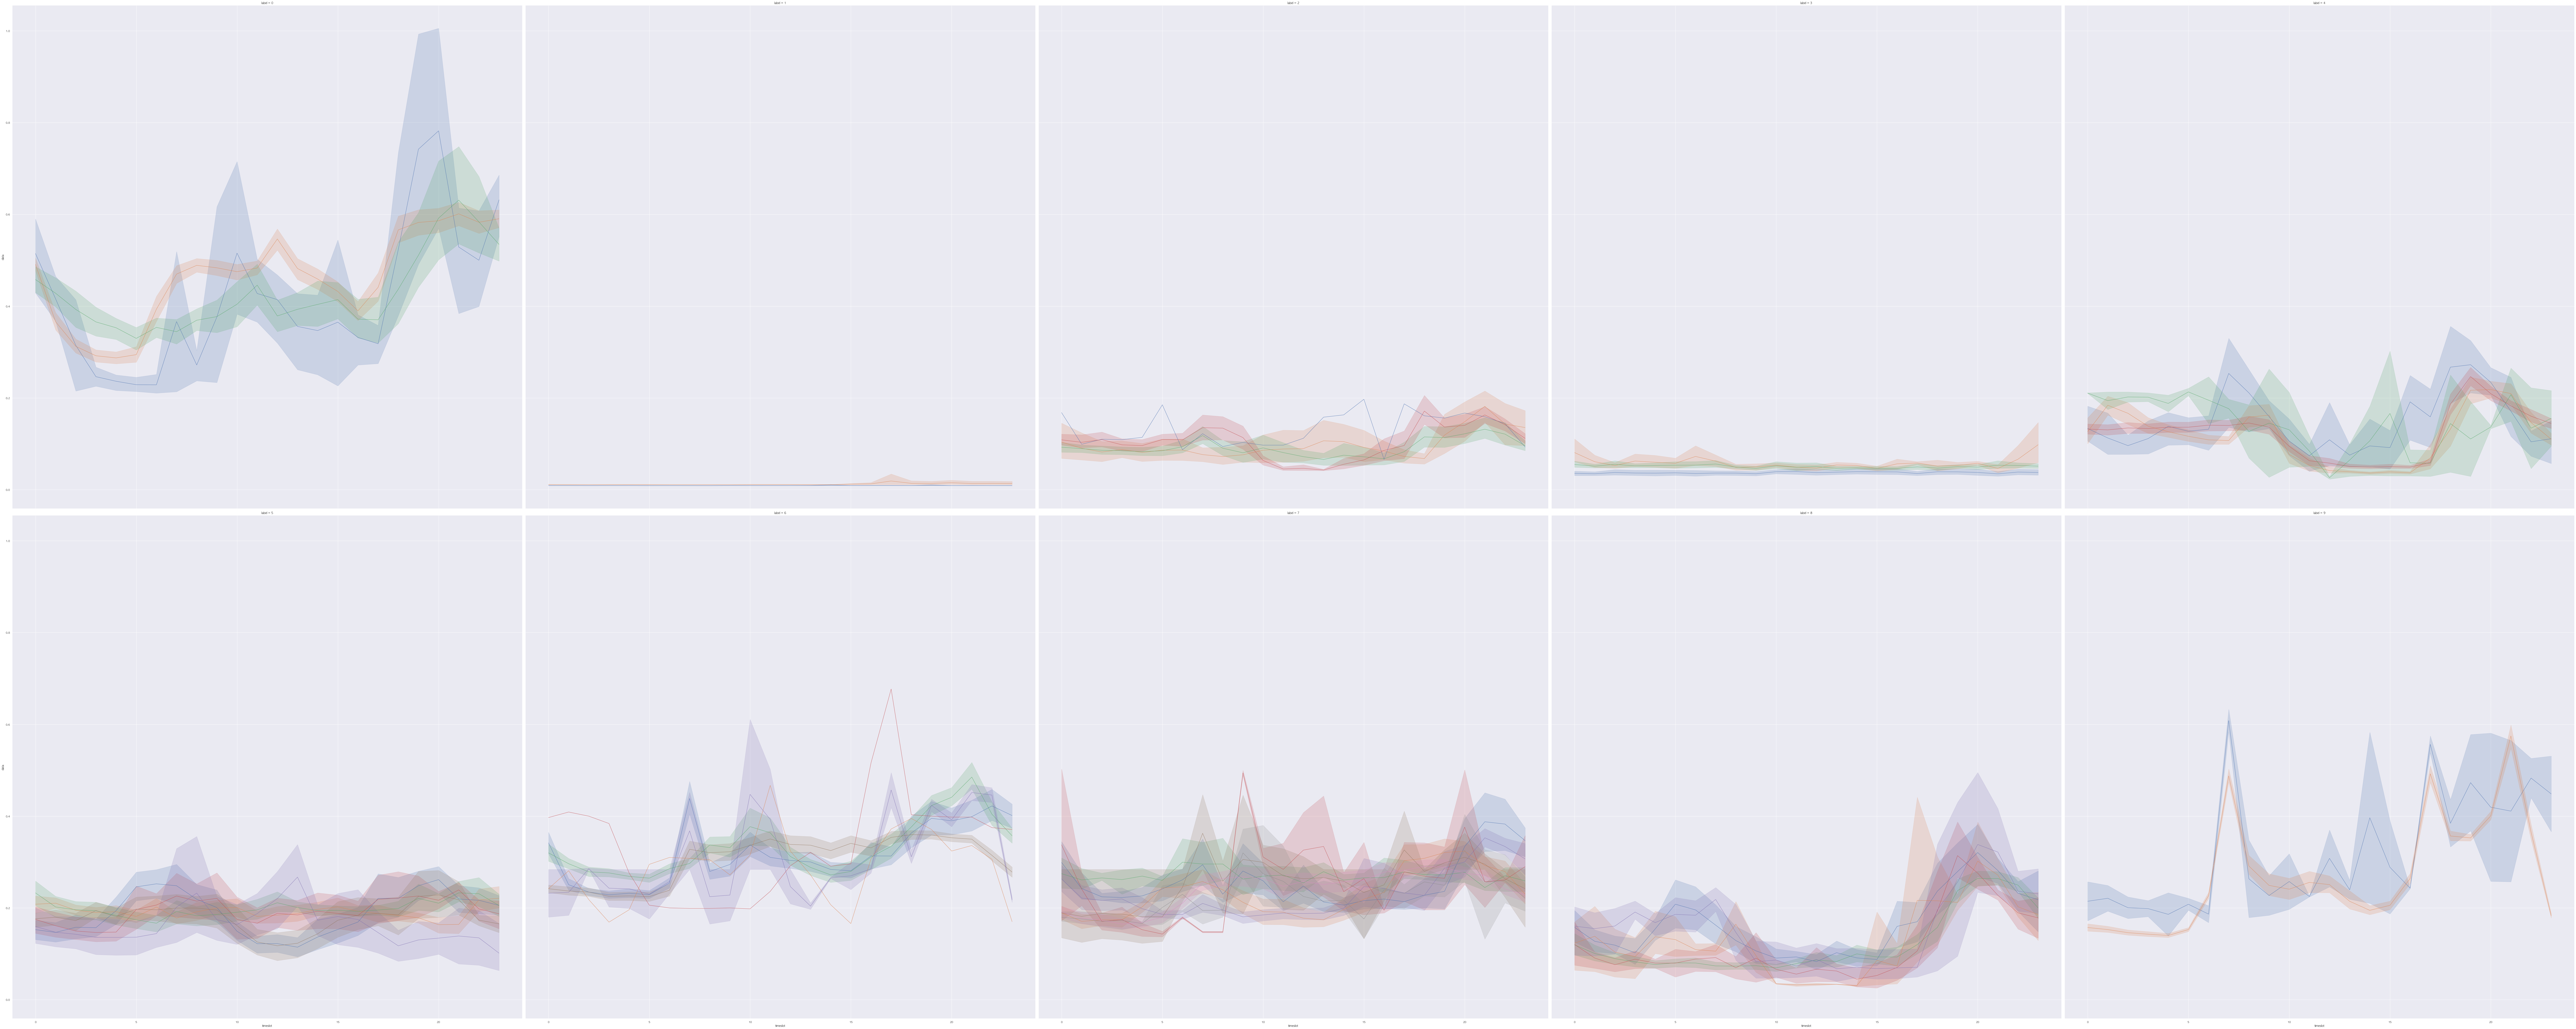

In [225]:
_map = sns.FacetGrid(sm.visual_datas, col="label", col_wrap=5, height=30) 
_map.map(sns.lineplot,
        "timeslot",
        "data",
         "uid",
        lw=1)

In [ ]:
from modules.SeasonMeans import SeasonMeans as SM

# TSS 변화에 따른 ECV 변화 체크
TSS_LIST = pd.DataFrame(columns=['tss'])

for data in og_datas:
    TSS_LIST.loc[data.uid] = [
        data.TSS()
    ]

SORT_TSS_LIST = TSS_LIST.sort_values(by=['tss'], ascending=False)

h_k = 5
tss_transition = pd.DataFrame(columns=['tss','wss', 'ecv'])

# Start
for test in range(0,10):
    target_datas = {}
    season = "봄"
    for k in range(h_k * test, h_k * (test + 1)):
        uid = SORT_TSS_LIST.iloc[k].name
        for data in og_datas:
            if data.uid == uid:
                target_datas[uid] = data.merge_datas[season]
                break
        
    index = pd.MultiIndex.from_tuples((), names=['uid', 'date'])
    all_datas = pd.DataFrame(columns=[idx for idx in range(0,24)],index=index)
    for uid in target_datas.keys():
        for date in target_datas[uid]:
            all_datas.loc[(uid, date.strftime("%Y%m%d")), :] = target_datas[uid][date].values

    sm = SM(all_datas)
    sm.run(K=10)
    
    tss_transition.loc[test] = [sm.tss, sm.wss, sm.ecv]

    print(tss_transition)

---Season Means---
---init TSS Check---
- calc TSS(Total Sum Of Squares) success!
---Dimension Reduction---
---Remove Outliers---
- dis_check: 0.6964315536719727, sim_check: 0.42922952592664204
- remove outlier success: 460 => 425
- calc TSS(Total Sum Of Squares) success!
---10:Clustering Start---
---Now 1---
---First Cluster Group Init---
---First K Select---
- First K Is ('아파트1-101-704', '20190317')
---Rest K Select---
- 2 K Is 아파트1-101-704/20190420
- 3 K Is 아파트1-101-704/20190323
- 4 K Is 아파트1-101-704/20180512
- 5 K Is 아파트1-101-704/20180511
- 6 K Is 아파트1-101-704/20190405
- 7 K Is 아파트1-101-704/20190428
- 8 K Is 아파트1-101-704/20180529
- 9 K Is 아파트1-101-402/20190318
- 10 K Is 아파트1-101-402/20180504
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 667.337837790501, WSS: 1095.6191530000008, ECV: -64.17758606757604
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 667.337837790501, WSS: 408.17606492256795, ECV: 38.8

- calc WSS success!
- calc ECV success!
TSS: 416.8193729869565, WSS: 259.12705789488524, ECV: 37.83229027049229
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 416.8193729869565, WSS: 257.6913174481526, ECV: 38.17674173790946
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 416.8193729869565, WSS: 255.93507566508728, ECV: 38.59808534544861
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 416.8193729869565, WSS: 253.95500993323284, ECV: 39.0731270206148
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 416.8193729869565, WSS: 251.99262647223506, ECV: 39.543926505517625
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 416.8193729869565, WSS: 251.37409369508285, ECV: 39.69231998654029
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV succ

- calc WSS success!
- calc ECV success!
TSS: 270.8004539647258, WSS: 168.5324382330382, ECV: 37.76508282552914
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 270.8004539647258, WSS: 166.05880229075362, ECV: 38.67853622121908
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 270.8004539647258, WSS: 164.1252650234088, ECV: 39.392544354897
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 270.8004539647258, WSS: 163.08980269312812, ECV: 39.77491532773721
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 270.8004539647258, WSS: 162.895564376904, ECV: 39.84664279841916
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 270.8004539647258, WSS: 162.7842999736611, ECV: 39.887730027636806
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!


- calc WSS success!
- calc ECV success!
TSS: 433.5006282739132, WSS: 134.4636779016646, ECV: 68.98189549642315
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 433.5006282739132, WSS: 134.4526321561654, ECV: 68.98444353090771
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 433.5006282739132, WSS: 134.40289754946426, ECV: 68.99591631859411
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 433.5006282739132, WSS: 134.28835609866297, ECV: 69.02233876030024
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 433.5006282739132, WSS: 134.2325309259278, ECV: 69.03521652081409
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 433.5006282739132, WSS: 134.22069228023727, ECV: 69.0379474616521
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success

- calc WSS success!
- calc ECV success!
TSS: 197.10075494406422, WSS: 113.20738741045598, ECV: 42.563696702945954
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 197.10075494406422, WSS: 112.59841881624668, ECV: 42.872659798689604
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 197.10075494406422, WSS: 112.27212527928918, ECV: 43.03820636752447
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 197.10075494406422, WSS: 112.23291038204222, ECV: 43.058102231068005
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 197.10075494406422, WSS: 112.2175425923393, ECV: 43.06589915183946
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 197.10075494406422, WSS: 112.2175425923393, ECV: 43.06589915183946
          tss         wss        ecv
0  667.337838  326.525835  51.070385
1 

- 6 K Is 아파트1-104-408/20190328
- 7 K Is 아파트1-104-408/20190326
- 8 K Is 아파트1-104-408/20190327
- 9 K Is 아파트1-104-408/20190402
- 10 K Is 아파트1-104-408/20190404
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 136.5334632961909, WSS: 228.48625200000023, ECV: -67.34816980678957
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 136.5334632961909, WSS: 55.3290046447056, ECV: 59.475865250208436
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 136.5334632961909, WSS: 52.467186740964614, ECV: 61.57192128998871
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 136.5334632961909, WSS: 51.57962178193659, ECV: 62.22199266267672
---Now 1---
---Cluster Init Okay KMeans Start---
- calc WSS success!
- calc ECV success!
TSS: 136.5334632961909, WSS: 51.203380692380286, ECV: 62.497559604635924
---Now 1---
---Cluster Init Okay KMeans Start---
- 

In [ ]:
# Clustering 수량에 따른 ECV 변화 체크